<a href="https://colab.research.google.com/github/Awakehsh/book-recommender-system/blob/main/book_rec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#  导入库
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
import torch
from transformers import BertTokenizer, BertModel, BatchEncoding
from torch.utils.data import Dataset, DataLoader  # for batch
import os
import random  # for sampling
import warnings
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
!pip install implicit
from implicit.als import AlternatingLeastSquares
from tqdm import tqdm
pd.set_option('display.max_columns', 500)
warnings.filterwarnings('ignore')
#!wget https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/ratings.csv -O ratings.csv
#!wget https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/tags.csv -O tags.csv
#!wget https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/book_tags.csv -O book_tags.csv
!wget https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/to_read.csv -O to_read.csv
# 挂载Drive
from google.colab import drive
drive.mount('/content/drive')
pd.set_option('display.max_columns', 500)
warnings.filterwarnings('ignore')
# 加载merged数据
output_path = '/content/drive/MyDrive/goodbooks_des_tags.csv'
df_books = pd.read_csv(output_path, encoding='utf-8')
print("加载形状:", df_books.shape)
print(df_books.head())  # 检查
print(df_books.isnull().sum())  # 空值

# 清洗
df_books.dropna(subset=['description'], inplace=True)

#df_ratings = pd.read_csv('ratings.csv')
df_to_read = pd.read_csv('to_read.csv')
print(len(df_to_read))


df_to_read['value'] = 1  # 显式标记行为
pivot = df_to_read.pivot_table(index='user_id', columns='book_id', values='value', fill_value=0)
print("pivot形状:", pivot.shape)
display(pivot)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 17.7 MB/s eta 0:00:00
--2025-08-05 13:31:54--  https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/to_read.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9407334 (9.0M) [text/plain]
Saving to: ‘to_read.csv’

to_read.csv         100%[===================>]   8.97M  21.1MB/s    in 0.4s    

2025-08-05 13:31:55 (21.1 MB/s) - ‘to_read.csv’ saved [9407334/9407334]

Mounted at /content/drive
加载形状: (10000, 26)
   book_id  goodreads_book_id  best_book_id  work_id  books_count       isbn  \
0        1            2767052       2767052  2792775          272  439023483   
1        2                  3             3  4640799          491  439554934   
2        3              41865         41865  32122

book_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,...,9751,9752,9753,9754,9755,9756,9757,9758,9759,9760,9761,9762,9763,9764,9765,9766,9767,9768,9769,9770,9771,9772,9773,9774,9775,9776,9777,9778,9779,9780,9781,9782,9783,9784,9785,9786,9787,9788,9789,9790,9791,9792,9793,9794,9795,9796,9797,9798,9799,9800,9801,9802,9803,9804,9805,9806,9807,9808,9809,9810,9811,9812,9813,9814,9815,9816,9817,9818,9819,9820,9821,9822,9823,9824,9825,9826,9827,9828,9829,9830,9831,9832,9833,9834,9835,9836,9837,9838,9839,9840,9841,9842,9843,9844,9845,9846,9847,9848,9849,9850,9851,9852,9853,9854,9855,9856,9857,9858,9859,9860,9861,9862,9863,9864,9865,9866,9867,9868,9869,9870,9871,9872,9873,9874,9875,9876,9877,9878,9879,9880,9881,9882,9883,9884,9885,9886,9887,9888,9889,9890,9891,9892,9893,9894,9895,9896,9897,9898,9899,9900,9901,9902,9903,9904,9905,9906,9907,9908,9909,9910,9911,9912,9913,9914,9915,9916,9917,9918,9919,9920,9921,9922,9923,9924,9925,9926,9927,9928,9929,9930,9931,9932,9933,9934,9935,9936,9937,9938,9939,9940,9941,9942,9943,9944,9945,9946,9947,9948,9949,9950,9951,9952,9953,9954,9955,9956,9957,9958,9959,9960,9961,9962,9963,9964,9965,9966,9967,9968,9969,9970,9971,9972,9973,9974,9975,9976,9977,9978,9979,9980,9981,9982,9983,9984,9985,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

## EDA


df_to_read 形状: (912705, 3)
             user_id        book_id     value
count  912705.000000  912705.000000  912705.0
mean    27668.980115    2454.739538       1.0
std     14775.096388    2626.359921       0.0
min         1.000000       1.000000       1.0
25%     15507.000000     360.000000       1.0
50%     27799.000000    1381.000000       1.0
75%     40220.000000    3843.000000       1.0
max     53424.000000   10000.000000       1.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912705 entries, 0 to 912704
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  912705 non-null  int64
 1   book_id  912705 non-null  int64
 2   value    912705 non-null  int64
dtypes: int64(3)
memory usage: 20.9 MB
None
独特用户数: 48871
独特书籍数: 9986
Pivot 形状: (48871, 9986)
矩阵稀疏度: 0.9981 (越高越稀疏，典型推荐数据>0.99)
用户标记书数统计:
count    48871.000000
mean        18.675800
std         16.089767
min          1.000000
25%          6.000000
50%         14.00

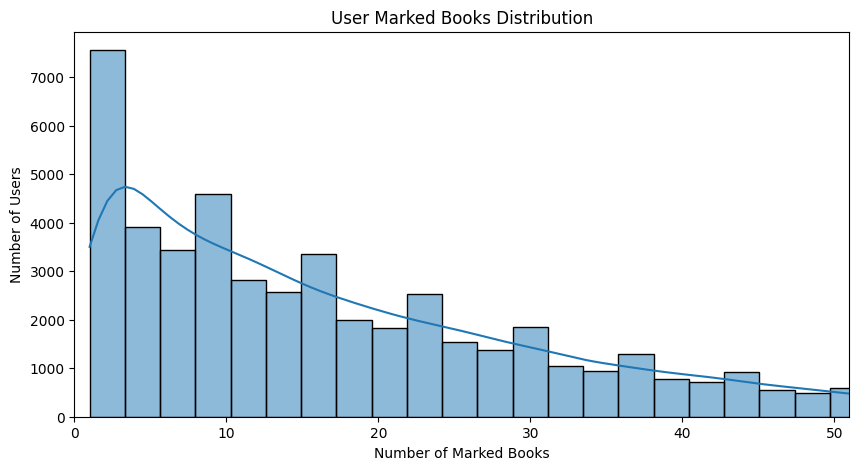

Top 5 活跃用户:
user_id
38457    117
28259    114
38076    110
44530    108
46000    107
Name: book_id, dtype: int64
书籍被标记统计:
count    9986.000000
mean       91.398458
std       160.557963
min         1.000000
25%        20.000000
50%        42.000000
75%        90.000000
max      2772.000000
Name: user_id, dtype: float64


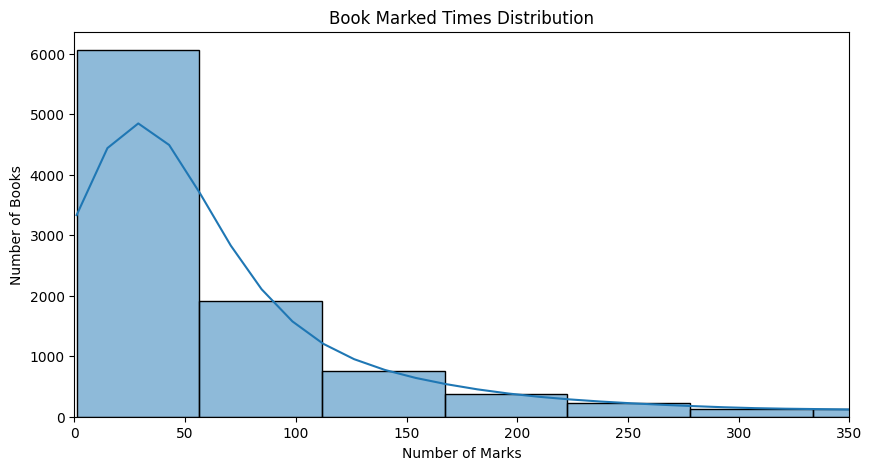

Top 10 热门书籍:
   book_id  user_id                                              title
0       47     2772                                     The Book Thief
1      143     1967                        All the Light We Cannot See
2      113     1840                                           Catch-22
3       13     1812                                               1984
4       11     1767                                    The Kite Runner
5       45     1717                                         Life of Pi
6      139     1650  Miss Peregrine’s Home for Peculiar Children (M...
7       39     1619     A Game of Thrones (A Song of Ice and Fire, #1)
8       65     1608                                Slaughterhouse-Five
9       35     1576                                      The Alchemist
描述长度统计:
count    10000.000000
mean       782.887500
std        576.311325
min         14.000000
25%        391.750000
50%        735.500000
75%       1057.250000
max       7638.000000
Name: desc_length, dty

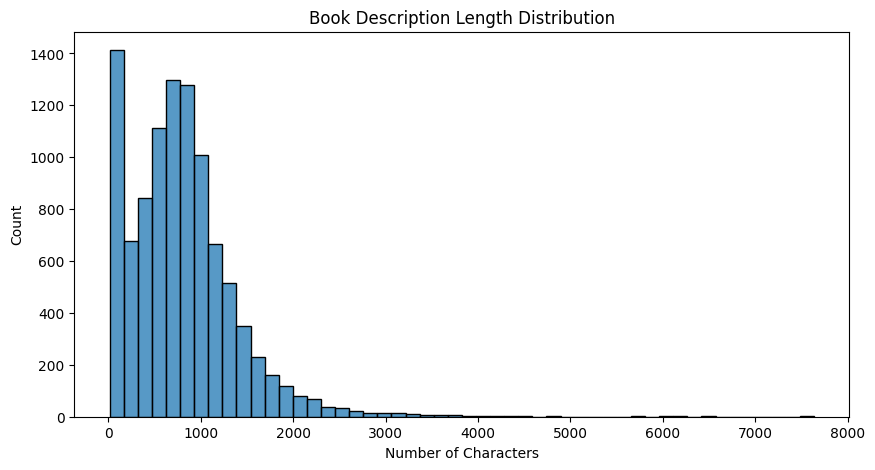

Top 20 常见词: ['best' 'book' 'family' 'just' 'life' 'like' 'love' 'man' 'new' 'novel'
 'old' 'people' 'story' 'time' 'way' 'world' 'year' 'years' 'york' 'young']
平均每个用户标记: 18.68 本
异常活跃用户数 (> 68.0): 462
平均每个用户标记: 18.68 本
异常活跃用户数 (> 68.0): 462


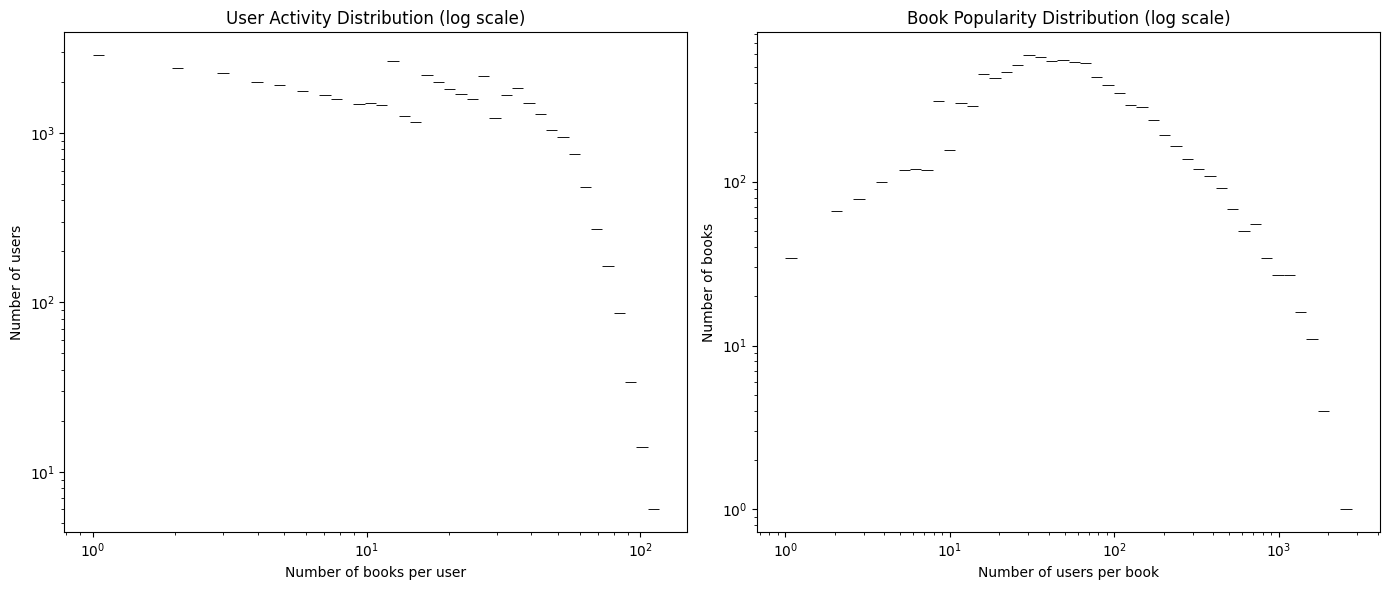

用户交互数分布描述：
count    48871.000000
mean        18.675800
std         16.089767
min          1.000000
25%          6.000000
50%         14.000000
75%         27.000000
max        117.000000
Name: book_id, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
# 安装字体

# 对于df_to_read（原始互动数据）
print("df_to_read 形状:", df_to_read.shape)
print(df_to_read.describe())  # 统计总结，如user_id和book_id的范围
print(df_to_read.info())  # 数据类型和非空计数
print("独特用户数:", df_to_read['user_id'].nunique())
print("独特书籍数:", df_to_read['book_id'].nunique())

# 对于pivot表（用户-书籍矩阵）
print("Pivot 形状:", pivot.shape)  # 行=用户，列=书籍
sparsity = 1 - (df_to_read.shape[0] / (pivot.shape[0] * pivot.shape[1]))
print(f"矩阵稀疏度: {sparsity:.4f} (越高越稀疏，典型推荐数据>0.99)")
# 计算每个用户标记的书数
user_activity = df_to_read.groupby('user_id')['book_id'].count().sort_values(ascending=False)
print("用户标记书数统计:")
print(user_activity.describe())  # 均值、中位数等

# 可视化：直方图（只看前1000避免长尾）
plt.figure(figsize=(10, 5))
sns.histplot(user_activity, bins=50, kde=True)
plt.title('User Marked Books Distribution')
plt.xlabel('Number of Marked Books')
plt.ylabel('Number of Users')
plt.xlim(0, user_activity.quantile(0.95))  # 忽略极端值
plt.show()

# 顶级活跃用户
print("Top 5 活跃用户:")
print(user_activity.head())
# 计算每个书籍被标记次数
book_popularity = df_to_read.groupby('book_id')['user_id'].count().sort_values(ascending=False)
print("书籍被标记统计:")
print(book_popularity.describe())

# 可视化
plt.figure(figsize=(10, 5))
sns.histplot(book_popularity, bins=50, kde=True)
plt.title('Book Marked Times Distribution')
plt.xlabel('Number of Marks')
plt.ylabel('Number of Books')
plt.xlim(0, book_popularity.quantile(0.95))
plt.show()

# 顶级热门书籍（合并df_books看标题）
top_books = book_popularity.head(10).reset_index()
top_books = top_books.merge(df_books[['book_id', 'title']], on='book_id', how='left')
print("Top 10 热门书籍:")
print(top_books)
# 描述长度分布
df_books['desc_length'] = df_books['description'].apply(len)
print("描述长度统计:")
print(df_books['desc_length'].describe())

# 可视化
plt.figure(figsize=(10, 5))
sns.histplot(df_books['desc_length'], bins=50)
plt.title('Book Description Length Distribution')
plt.xlabel('Number of Characters')
plt.show()

# 常见词（用TF-IDF简单看，但先词频）
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', max_features=20)
word_counts = vectorizer.fit_transform(df_books['description'])
common_words = vectorizer.get_feature_names_out()
print("Top 20 常见词:", common_words)
# 用户平均标记书数
avg_marks = user_activity.mean()
print(f"平均每个用户标记: {avg_marks:.2f} 本")

# 异常：标记>阈值的用户（e.g., 99分位）
threshold = user_activity.quantile(0.99)
outliers = user_activity[user_activity > threshold]
print(f"异常活跃用户数 (> {threshold}): {len(outliers)}")
# 用户平均标记书数
avg_marks = user_activity.mean()
print(f"平均每个用户标记: {avg_marks:.2f} 本")

# 异常：标记>阈值的用户（e.g., 99分位）
threshold = user_activity.quantile(0.99)
outliers = user_activity[user_activity > threshold]
print(f"异常活跃用户数 (> {threshold}): {len(outliers)}")


# 用户活跃度分布：每个用户交互了多少本书
user_counts = df_to_read.groupby('user_id')['book_id'].count()

# 图书热度分布：每本书被多少用户交互
book_counts = df_to_read.groupby('book_id')['user_id'].count()

plt.figure(figsize=(14, 6))

# 用户活跃度直方图
plt.subplot(1, 2, 1)
sns.histplot(user_counts, bins=50, log_scale=(True, True))
plt.title("User Activity Distribution (log scale)")
plt.xlabel("Number of books per user")
plt.ylabel("Number of users")

# 图书热度直方图
plt.subplot(1, 2, 2)
sns.histplot(book_counts, bins=50, log_scale=(True, True))
plt.title("Book Popularity Distribution (log scale)")
plt.xlabel("Number of users per book")
plt.ylabel("Number of books")

plt.tight_layout()
plt.show()
user_counts = df_to_read.groupby('user_id')['book_id'].count()
print("用户交互数分布描述：")
print(user_counts.describe())


## 函数导入


In [ ]:
# Step 1: Data Preprocessing
# Filter out cold users and books to reduce sparsity and improve efficiency
min_user_marks = 5
min_book_marks = 20
# Data Preprocessing Function
def preprocess_data(interactions_df, min_user_marks=6, min_book_marks=20):
    """
    Filter out cold users and books to reduce sparsity.

    Args:
        interactions_df (pd.DataFrame): User-book interaction data.
        min_user_marks (int): Minimum interactions per user.
        min_book_marks (int): Minimum interactions per book.

    Returns:
        pd.DataFrame: Filtered interaction data.
    """
    df_filtered = interactions_df.copy()
    while True:
        old_len = len(df_filtered)
        user_act = df_filtered.groupby('user_id')['book_id'].count()
        df_filtered = df_filtered[df_filtered['user_id'].isin(user_act[user_act >= min_user_marks].index)]
        book_pop = df_filtered.groupby('book_id')['user_id'].count()
        df_filtered = df_filtered[df_filtered['book_id'].isin(book_pop[book_pop >= min_book_marks].index)]
        if len(df_filtered) == old_len:
            break
    print("Filtered interactions:", len(df_filtered))
    return df_filtered
def evaluate_cf(train_df, test_df, recommend_func, pivot, K=5, sample_users=500):
    """
    Evaluate CF recommendation function using Precision@K, Recall@K, and HitRate@K.

    Args:
        train_df (pd.DataFrame): Training data.
        test_df (pd.DataFrame): Test data.
        recommend_func (function): Recommendation function to evaluate.
        pivot (pd.DataFrame): User-item pivot table.
        K (int): Number of recommendations.
        sample_users (int): Number of users to sample for evaluation.

    Returns:
        dict: Evaluation metrics.
    """
    test_users = list(set(test_df['user_id'].unique()) & set(pivot.index))
    test_users = [u for u in test_users if pivot.loc[u].sum() > 0]

    if sample_users:
        random.seed(42)
        test_users = random.sample(test_users, min(sample_users, len(test_users)))

    prec_sum, rec_sum, hit_users = 0.0, 0.0, 0
    for u in tqdm(test_users, desc=f"Evaluating {recommend_func.__name__}"):
        pos_items = set(test_df[test_df['user_id'] == u]['book_id'])
        recs = set(recommend_func(u, K, pivot=pivot)['book_id'])
        hit = len(recs & pos_items)
        prec_sum += hit / K
        rec_sum += hit / max(1, len(pos_items))
        if hit > 0:
            hit_users += 1

    n = len(test_users)
    if n == 0:
        return {'Precision@K': 0, 'Recall@K': 0, 'HitRate@K': 0}
    return {
        'users': n,
        'Precision@K': prec_sum / n,
        'Recall@K': rec_sum / n,
        'HitRate@K': hit_users / n
    }

# Evaluation Function for CBF
def evaluate_cbf(test_df, recommend_func, books_df, K=5, sample_users=500):
    """评估CBF推荐函数的Precision@K, Recall@K, HitRate@K"""
    test_users = test_df['user_id'].unique()
    if sample_users:
        random.seed(42)
        test_users = random.sample(list(test_users), min(sample_users, len(test_users)))

    prec_sum, rec_sum, hit_users = 0.0, 0.0, 0
    for u in tqdm(test_users, desc=f"Evaluating {recommend_func.__name__}"):
        pos_items = set(test_df[test_df['user_id'] == u]['book_id'])
        recs = set(recommend_func(u, K, interactions_df=train)['book_id'])  # 用train作为历史
        hit = len(recs & pos_items)
        prec_sum += hit / K
        rec_sum += hit / max(1, len(pos_items))
        if hit > 0:
            hit_users += 1

    n = len(test_users)
    if n == 0:
        return {'Precision@K': 0, 'Recall@K': 0, 'HitRate@K': 0}
    return {
        'users': n,
        'Precision@K': prec_sum / n,
        'Recall@K': rec_sum / n,
        'HitRate@K': hit_users / n
    }

# Hybrid评价函数
def evaluate_hybrid(train, test, recommender, pivot, K=5, **kwargs):
    """评估hybrid模型，支持额外参数传递给recommender（已适应weighted）"""
    users = test['user_id'].unique()[:500]  # 假设取前500用户
    precision, recall, hit = [], [], []

    for user_id in tqdm(users, desc="Evaluating recommend_hybrid"):
        test_books = set(test[test['user_id'] == user_id]['book_id'])
        if not test_books:
            continue
        rec_df = recommender(user_id, K, pivot, **kwargs)  # 传递**kwargs（只cf_weight和cbf_weight）
        rec_books = set(rec_df['book_id'])

        hits = len(rec_books & test_books)
        precision.append(hits / K if K > 0 else 0)
        recall.append(hits / len(test_books) if len(test_books) > 0 else 0)
        hit.append(1 if hits > 0 else 0)
    n = len(users)
    metrics = {
        'users': n,
        'Precision@K': sum(precision) / n,
        'Recall@K': sum(recall) / n,
        'HitRate@K': sum(hit) / n
    }
    return metrics
df_filtered = preprocess_data(df_to_read)
display(df_filtered.head())
train, test = train_test_split(df_filtered, test_size=0.2, random_state=42)


Filtered interactions: 849075


,user_id,book_id,value
0,9,8,1
1,15,398,1
2,15,275,1
4,34,380,1
5,34,483,1


##cf


In [ ]:
pivot_train = train.pivot_table(index='user_id', columns='book_id', values='value', fill_value=0)
item_ids = pivot_train.columns.to_numpy()
user_ids = pivot_train.index.to_numpy()
item_pos = {bid: i for i, bid in enumerate(item_ids)}
user_pos = {uid: i for i, uid in enumerate(user_ids)}
# Sparse matrices for item-based and user-based models
item_matrix_sparse = csr_matrix(pivot_train.T)  # Books x Users
user_matrix_sparse = csr_matrix(pivot_train)    # Users x Books
print("Item matrix shape:", item_matrix_sparse.shape)
print("User matrix shape:", user_matrix_sparse.shape)

Item matrix shape: (7373, 36888)
User matrix shape: (36888, 7373)


### memory base


In [ ]:
# Item-based KNN
knn_item = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn_item.fit(item_matrix_sparse)
def recommend_item_knn(user_id, K=5, pivot=pivot_train):
    """Recommend top-K books using item-based KNN."""
    if user_id not in pivot.index:
        return pd.DataFrame()  # Handle cold-start
    user_row = pivot.loc[user_id]
    seeds = user_row[user_row > 0].index.to_list()
    if not seeds:
        return pd.DataFrame()
    scores = {}
    seed_indices = [item_pos.get(b) for b in seeds if item_pos.get(b) is not None]
    if not seed_indices:
        return pd.DataFrame()
    seed_vectors = item_matrix_sparse[seed_indices]
    dist, ind = knn_item.kneighbors(seed_vectors, n_neighbors=K+1)

    # Aggregate scores
    for i in range(len(seed_indices)):
        distances = dist[i][1:]  # Skip self
        indices = ind[i][1:]     # Skip self
        for j, d in zip(indices, distances):
            cand = item_ids[j]
            if cand in seeds:
                continue
            scores[cand] = scores.get(cand, 0) + (1 - d)

    if scores:
        num_seeds = len(seeds)
        for cand in scores:
            scores[cand] /= num_seeds  # Normalize scores

    sorted_recs = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:K]
    rec_books = [bid for bid, _ in sorted_recs]
    rec_df = pd.DataFrame({'book_id': rec_books}).merge(df_books[['book_id', 'title']], on='book_id', how='left')
    return rec_df

user_id = 1
K = 5

# Item-based KNN
print(f"\n用户 {user_id} 在训练集中的阅读记录：")
print(train[train['user_id'] == user_id].merge(df_books[['book_id', 'title']], on='book_id', how='left'))
print(f"\n用户 {user_id} 在测试集中的阅读记录：")
print(test[test['user_id'] == user_id].merge(df_books[['book_id', 'title']], on='book_id', how='left'))
print(f"\n用户 {user_id} 的 Top-{K} 推荐 (Item-based KNN)：")
print(recommend_item_knn(user_id, K))

print("\nEvaluating models...")
metrics_item_knn = evaluate_cf(train, test, recommend_item_knn, pivot_train, K=5)
print("Item-based KNN metrics:", metrics_item_knn)


用户 1 在训练集中的阅读记录：
   user_id  book_id  value                                            title
0        1     1874      1                               The Aviator's Wife
1        1      533      1                                Go Set a Watchman
2        1     3334      1                        The Marriage of Opposites
3        1      112      1                Me Before You (Me Before You, #1)
4        1     1198      1                                    A Little Life
5        1     2058      1  My Grandmother Asked Me to Tell You She's Sorry

用户 1 在测试集中的阅读记录：
   user_id  book_id  value                 title
0        1      235      1  The Husband's Secret

用户 1 的 Top-5 推荐 (Item-based KNN)：
   book_id                        title
0      267              The Nightingale
1     1220             Fates and Furies
2       61        The Girl on the Train
3      143  All the Light We Cannot See
4     2003             Circling the Sun

Evaluating models...


Evaluating recommend_item_knn: 100%|██████████| 500/500 [00:19<00:00, 25.48it/s]

Item-based KNN metrics: {'users': 500, 'Precision@K': 0.06559999999999992, 'Recall@K': 0.0699199723621079, 'HitRate@K': 0.24}


In [ ]:
# User-based KNN
knn_user = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn_user.fit(user_matrix_sparse)
def recommend_user_knn(user_id, K=5, pivot=pivot_train):
    """Recommend top-K books using user-based KNN."""
    if user_id not in pivot.index:
        return pd.DataFrame()  # Handle cold-start
    user_idx = user_pos.get(user_id)
    if user_idx is None:
        return pd.DataFrame()

    user_vec = user_matrix_sparse[user_idx]
    dist, ind = knn_user.kneighbors(user_vec, n_neighbors=20)  # Fetch more neighbors
    dist = dist.ravel()[1:]  # Skip self
    ind = ind.ravel()[1:]

    user_books = set(pivot.loc[user_id][pivot.loc[user_id] > 0].index)
    scores = {}
    for neighbor_idx, distance in zip(ind, dist):
        neighbor_id = user_ids[neighbor_idx]
        neighbor_books = set(pivot.loc[neighbor_id][pivot.loc[neighbor_id] > 0].index)
        for book in neighbor_books:
            if book in user_books:
                continue
            scores[book] = scores.get(book, 0) + (1 - distance)

    if scores:
        num_neighbors = len(ind)
        for book in scores:
            scores[book] /= num_neighbors  # Normalize scores

    sorted_recs = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:K]
    rec_books = [bid for bid, _ in sorted_recs]
    rec_df = pd.DataFrame({'book_id': rec_books}).merge(df_books[['book_id', 'title']], on='book_id', how='left')
    return rec_df

# User-based KNN
user_id = 1
K = 5

# Item-based KNN
print(f"\n用户 {user_id} 在训练集中的阅读记录：")
print(train[train['user_id'] == user_id].merge(df_books[['book_id', 'title']], on='book_id', how='left'))
print(f"\n用户 {user_id} 在测试集中的阅读记录：")
print(test[test['user_id'] == user_id].merge(df_books[['book_id', 'title']], on='book_id', how='left'))
print(f"\n 用户 {user_id} 的 Top-{K} 推荐 (User-based KNN)：")
print(recommend_user_knn(user_id, K))

metrics_user_knn = evaluate_cf(train, test, recommend_user_knn, pivot_train, K=5)
print("User-based KNN metrics:", metrics_user_knn)


用户 1 在训练集中的阅读记录：
   user_id  book_id  value                                            title
0        1     1874      1                               The Aviator's Wife
1        1      533      1                                Go Set a Watchman
2        1     3334      1                        The Marriage of Opposites
3        1      112      1                Me Before You (Me Before You, #1)
4        1     1198      1                                    A Little Life
5        1     2058      1  My Grandmother Asked Me to Tell You She's Sorry

用户 1 在测试集中的阅读记录：
   user_id  book_id  value                 title
0        1      235      1  The Husband's Secret

 用户 1 的 Top-5 推荐 (User-based KNN)：
   book_id                  title
0     1028     Truly Madly Guilty
1     3908           The Royal We
2     1740  In the Unlikely Event
3     1220       Fates and Furies
4     3064                 Purity


Evaluating recommend_user_knn: 100%|██████████| 500/500 [00:20<00:00, 24.99it/s]

User-based KNN metrics: {'users': 500, 'Precision@K': 0.04799999999999996, 'Recall@K': 0.049963532219414554, 'HitRate@K': 0.168}


### model base

In [ ]:
# ALS (Model-based Collaborative Filtering)
als_model = AlternatingLeastSquares(factors=100, iterations=50, regularization=0.1, random_state=42)
als_model.fit(user_matrix_sparse)

def recommend_als(user_id, K=5, pivot=pivot_train):
    """Recommend top-K books using ALS."""
    if user_id not in pivot.index:
        return pd.DataFrame()  # Handle cold-start
    user_idx = user_pos.get(user_id)
    if user_idx is None:
        return pd.DataFrame()

    rec_indices, scores = als_model.recommend(user_idx, user_matrix_sparse[user_idx], N=K, filter_already_liked_items=True)
    rec_books = item_ids[rec_indices]
    rec_df = pd.DataFrame({'book_id': rec_books}).merge(df_books[['book_id', 'title']], on='book_id', how='left')
    return rec_df


# ALS
user_id = 1
K = 5

print(f"\n用户 {user_id} 在训练集中的阅读记录：")
print(train[train['user_id'] == user_id].merge(df_books[['book_id', 'title']], on='book_id', how='left'))
print(f"\n用户 {user_id} 在测试集中的阅读记录：")
print(test[test['user_id'] == user_id].merge(df_books[['book_id', 'title']], on='book_id', how='left'))
print(f"\n用户 {user_id} 的 Top-{K} 推荐 (ALS)：")
print(recommend_als(user_id, K))

metrics_als = evaluate_cf(train, test, recommend_als, pivot_train, K=5)
print("ALS metrics:", metrics_als)

  0%|          | 0/50 [00:00<?, ?it/s]


用户 1 在训练集中的阅读记录：
   user_id  book_id  value                                            title
0        1     1874      1                               The Aviator's Wife
1        1      533      1                                Go Set a Watchman
2        1     3334      1                        The Marriage of Opposites
3        1      112      1                Me Before You (Me Before You, #1)
4        1     1198      1                                    A Little Life
5        1     2058      1  My Grandmother Asked Me to Tell You She's Sorry

用户 1 在测试集中的阅读记录：
   user_id  book_id  value                 title
0        1      235      1  The Husband's Secret

用户 1 的 Top-5 推荐 (ALS)：
   book_id                                              title
0      470  I Am Malala: The Story of the Girl Who Stood U...
1       83                               A Tale of Two Cities
2      267                                    The Nightingale
3      217  The Devil in the White City: Murder, Magic, an...


Evaluating recommend_als: 100%|██████████| 500/500 [00:05<00:00, 84.19it/s] 

ALS metrics: {'users': 500, 'Precision@K': 0.03599999999999996, 'Recall@K': 0.0354435745197355, 'HitRate@K': 0.15}


##cbf


In [ ]:
# 移除无效tags
print(len(df_filtered))
print(df_books['tag_name'].isna().sum())  # 空值数 = 0
print((df_books['tag_name'].str.strip().str.lower() == "no tags").sum())  # 无效tag数 = 0
print((df_books['tag_name'].str.strip() == "").sum())  # 空字符串数 = 0



849075
0
0
0


### TF—idf


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# 自定义stopwords（可按需扩充）
custom_stop = [
    # Goodreads标签词（无语义）
    'favorites', 'currently-reading', 'to-read', 'books-i-own', 'owned', 'read', 'library', 'my-books', 'tbr',
    # 数字类（年份、序号）
    '00', '000', '01', '02', '03', '04', '06', '08', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
    '21', '22', '23', '25', '30', '33', '39', '40', '50', '52', '65', '75', '80', '90', '100', '200', '300', '500',
    '800', '1000', '1001', '10k', '20s', '80s', '90s',
    '1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th',
    '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th', '21st',
    '1500s', '1600s', '1700s', '1800', '1800s', '1830s', '1880s', '1890s', '1900', '1900s', '1910s', '1920', '1920s',
    '1930', '1930s', '1939', '1940s', '1945', '1950s', '1960', '1960s', '1970', '1970s', '1975', '1979', '1980',
    '1980s', '1987', '1988', '1989', '1990', '1990s', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999',
    '2000', '2000s', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2010s', '2011',
    '2012', '2013', '2014', '2015', '2016', '2017', '2018',
    # 英语通用停用词（部分）
    'an', 'and', 'as', 'at', 'against', 'after', 'again', 'always', 'are', 'about', 'actual', 'actually',
    # 与出版格式、状态相关（无信息量）
    'arc', 'arcs', 'audible', 'available', 'added', 'already', 'adapted', 'adaptation',
    'adaptations',
    # 高频垃圾词 / 无判别力标签词
    'books', 'fiction', 'book', 'abc', '0wn', 'abandonados', 'abandoned', 'abandonment',
    'absolute', 'absolutely', 'absurd', 'absurdism', 'actor',
    'actors', 'actresses', 'adolescence', 'adolescent','adultery', 'addiction',
    'affairs', 'affair', 'adaptation', 'advice', 'advisory',  'acceptance', 'aching',
    'acquire', 'available','announcement', 'announcement', 'announcement',
    # 一些明显无意义的代号/代码
    '007', '230', '291', '307', '311', '314', '325', '355', '3601', '420', '501', '5360', '614', '642', "1001books" ,'32','66','60s' ,'645','aa','aar','ab'
]

# 统一数据源：df_books（10000本书）
df_books['text_tags'] = df_books['tag_name']
book_ids = df_books['book_id'].values
book_pos = {bid: idx for idx, bid in enumerate(book_ids)}

# TF-IDF 特征
vectorizer = TfidfVectorizer(max_features=5000, stop_words=['english'] + custom_stop)
tfidf_matrix = vectorizer.fit_transform(df_books['text_tags'])
cosine_sim = cosine_similarity(tfidf_matrix)

print(f"TF-IDF矩阵形状：{tfidf_matrix.shape}")
print(f"相似性矩阵形状：{cosine_sim.shape}")
print("Top特征词：", vectorizer.get_feature_names_out()[:20])
def recommend_cbf_tfidf_tags(user_id, K=5, interactions_df=df_filtered, sim_matrix=cosine_sim):
    user_books = set(interactions_df[interactions_df['user_id'] == user_id]['book_id'])
    if not user_books:
        return pd.DataFrame()

    user_indices = [book_pos[book_id] for book_id in user_books if book_id in book_pos]
    if not user_indices:
        return pd.DataFrame()

    agg_scores = np.sum(sim_matrix[user_indices], axis=0)
    agg_scores[user_indices] = 0  # 排除已看过的
    agg_scores /= len(user_indices)

    top_indices = np.argsort(agg_scores)[::-1][:K]
    rec_books = book_ids[top_indices]

    return pd.DataFrame({'book_id': rec_books}).merge(df_books[['book_id', 'title']], on='book_id', how='left')
user_id = 1
K = 5

print(f"\n用户 {user_id} 的历史阅读记录：")
print(train[train['user_id'] == user_id].merge(df_books[['book_id', 'title']], on='book_id', how='left'))

print(f"\n用户 {user_id} 在测试集中的阅读记录：")
print(test[test['user_id'] == user_id].merge(df_books[['book_id', 'title']], on='book_id', how='left'))

print(f"\n 用户 {user_id} 的 Top-{K} 推荐（Tags TF-IDF CBF）：")
print(recommend_cbf_tfidf_tags(user_id, K, interactions_df=train))

metrics = evaluate_cbf(test, recommend_cbf_tfidf_tags, df_filtered, K=5, sample_users=500)
print("\nTags TF-IDF CBF评估指标：")
print(metrics)

TF-IDF矩阵形状：(10000, 5000)
相似性矩阵形状：(10000, 10000)
Top特征词： ['_owned' 'abbey' 'abbi' 'abbott' 'abduction' 'abercrombie' 'aboriginal'
 'abortion' 'abraham' 'abuse' 'abused' 'academia' 'academic' 'academy'
 'accident' 'acting' 'action' 'activism' 'adam' 'adams']

用户 1 的历史阅读记录：
   user_id  book_id  value                                            title
0        1     1874      1                               The Aviator's Wife
1        1      533      1                                Go Set a Watchman
2        1     3334      1                        The Marriage of Opposites
3        1      112      1                Me Before You (Me Before You, #1)
4        1     1198      1                                    A Little Life
5        1     2058      1  My Grandmother Asked Me to Tell You She's Sorry

用户 1 在测试集中的阅读记录：
   user_id  book_id  value                 title
0        1      235      1  The Husband's Secret

 用户 1 的 Top-5 推荐（Tags TF-IDF CBF）：
   book_id                      title
0     

Evaluating recommend_cbf_tfidf_tags: 100%|██████████| 500/500 [00:01<00:00, 268.30it/s]


Tags TF-IDF CBF评估指标：
{'users': 500, 'Precision@K': 0.029999999999999968, 'Recall@K': 0.03228965478965478, 'HitRate@K': 0.122}


In [ ]:
# 使用过滤后数据（df_filtered）构建 description 字段
df_books['text_des'] = df_books['description']

#  清洗 description 字段（保持最基本规则）
df_books_des = df_books[
    (df_books['description'].str.strip().str.lower().isin([
        'no description', 'unknown', 'n/a', 'tba', 'not available', 'description unavailable']) == False)
]
df_books_des = df_books_des[df_books_des['description'].str.strip().str.len() >= 20]
print(f"有效 description 行数：{len(df_books_des)}")
valid_books = set(df_books_des['book_id'])
df_filtered_des = df_filtered[df_filtered['book_id'].isin(valid_books)]
print(f"过滤后交互数：{len(df_filtered_des)}")

#  构建 TF-IDF 特征（description）
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

custom_stop = [
    'published', 'edition', 'paperback', 'hardcover', 'isbn', 'author', 'story', 'novel', 'tells', 'written',
    'aaron', 'abby', 'abraham', 'adam', 'adams', 'al', 'alan', 'alanna', 'alex'
]
custom_stop += stopwords.words('english')

vectorizer = TfidfVectorizer(max_features=5000, stop_words=custom_stop, min_df=5)
tfidf_matrix = vectorizer.fit_transform(df_books_des['text_des'])
print(f"TF-IDF矩阵形状（description）：{tfidf_matrix.shape}")

# 构建相似度矩阵
cosine_sim = cosine_similarity(tfidf_matrix)
print(f"相似度矩阵形状：{cosine_sim.shape}")

#  构建索引映射
book_ids = df_books_des['book_id'].to_numpy()
book_pos = {bid: i for i, bid in enumerate(book_ids)}

#  推荐函数
def recommend_cbf_tfidf_des(user_id, K=5, interactions_df=df_filtered_des, sim_matrix=cosine_sim):
    user_books = set(interactions_df[interactions_df['user_id'] == user_id]['book_id'])
    if not user_books:
        return pd.DataFrame()

    user_indices = [book_pos.get(book_id) for book_id in user_books if book_id in book_pos]
    if not user_indices:
        return pd.DataFrame()

    agg_scores = np.sum(sim_matrix[user_indices], axis=0)
    agg_scores[user_indices] = 0
    agg_scores /= len(user_books)

    top_indices = np.argsort(agg_scores)[::-1][:K]
    rec_books = book_ids[top_indices]

    return pd.DataFrame({'book_id': rec_books}).merge(df_books[['book_id', 'title']], on='book_id', how='left')

#  测试 & 评估
user_id = 1
K = 5
print(f"\n用户 {user_id} 的训练集历史：")
print(train[train['user_id'] == user_id].merge(df_books[['book_id', 'title']], on='book_id', how='left'))

print(f"\n用户 {user_id} 的测试集历史：")
print(test[test['user_id'] == user_id].merge(df_books[['book_id', 'title']], on='book_id', how='left'))

print(f"\n用户 {user_id} 的 Top-{K} 推荐（Description TF-IDF）：")
print(recommend_cbf_tfidf_des(user_id, K=K, interactions_df=train))

metrics = evaluate_cbf(test, recommend_cbf_tfidf_des, df_books, K=5, sample_users=500)
print("\n📊 Description TF-IDF CBF评估指标：")
print(metrics)

有效 description 行数：8803
过滤后交互数：775643


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


TF-IDF矩阵形状（description）：(8803, 5000)
相似度矩阵形状：(8803, 8803)

用户 1 的训练集历史：
   user_id  book_id  value                                            title
0        1     1874      1                               The Aviator's Wife
1        1      533      1                                Go Set a Watchman
2        1     3334      1                        The Marriage of Opposites
3        1      112      1                Me Before You (Me Before You, #1)
4        1     1198      1                                    A Little Life
5        1     2058      1  My Grandmother Asked Me to Tell You She's Sorry

用户 1 的测试集历史：
   user_id  book_id  value                 title
0        1      235      1  The Husband's Secret

用户 1 的 Top-5 推荐（Description TF-IDF）：
   book_id                                title
0     6676                  You Had Me At Hello
1      566        After You (Me Before You, #2)
2     1913  Rachel's Holiday (Walsh Family, #2)
3     6107            The Swans of Fifth Avenue
4     

Evaluating recommend_cbf_tfidf_des: 100%|██████████| 500/500 [00:01<00:00, 274.22it/s]


📊 Description TF-IDF CBF评估指标：
{'users': 500, 'Precision@K': 0.018400000000000007, 'Recall@K': 0.018236507936507936, 'HitRate@K': 0.062}


### BERT

In [ ]:
#  安装与导入
!pip install sentence-transformers --quiet

from sentence_transformers import SentenceTransformer
import torch

# 加载模型（使用 GPU）
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer('all-mpnet-base-v2', device=device)
print("✅ BERT加载完成，使用设备：", model.device)

# 对 description 嵌入
embeddings = model.encode(df_books_des['description'].tolist(), show_progress_bar=True, batch_size=128)
print(f"✅ BERT Embeddings 形状：{embeddings.shape}")

#  相似度矩阵（基于 cosine）
cosine_sim = cosine_similarity(embeddings)
print(f"✅ 相似度矩阵形状：{cosine_sim.shape}")

#: book_id → 位置索引映射
book_ids = df_books_des['book_id'].to_numpy()
book_pos = {bid: i for i, bid in enumerate(book_ids)}

#  推荐函数
def recommend_cbf_bert_des(user_id, K=5, interactions_df=df_filtered_des, sim_matrix=cosine_sim):
    user_books = set(interactions_df[interactions_df['user_id'] == user_id]['book_id'])
    if not user_books:
        return pd.DataFrame()

    user_indices = [book_pos.get(book_id) for book_id in user_books if book_id in book_pos]
    if not user_indices:
        return pd.DataFrame()

    agg_scores = np.sum(sim_matrix[user_indices], axis=0)
    agg_scores[user_indices] = 0
    agg_scores /= len(user_books)

    top_indices = np.argsort(agg_scores)[::-1][:K]
    rec_books = book_ids[top_indices]

    return pd.DataFrame({'book_id': rec_books}).merge(df_books[['book_id', 'title']], on='book_id', how='left')

#  测试
user_id = 1
K = 5

print(f"\n📘 用户 {user_id} 的训练集历史：")
print(train[train['user_id'] == user_id].merge(df_books[['book_id', 'title']], on='book_id', how='left'))

print(f"\n📘 用户 {user_id} 的测试集历史：")
print(test[test['user_id'] == user_id].merge(df_books[['book_id', 'title']], on='book_id', how='left'))

print(f"\n📘 用户 {user_id} 的 Top-{K} 推荐结果（BERT Description CBF）：")
print(recommend_cbf_bert_des(user_id, K, interactions_df=train))

#  评估
metrics = evaluate_cbf(test, recommend_cbf_bert_des, df_books, K=5, sample_users=500)
print("\n📊 BERT Description CBF 推荐评估指标：")
print(metrics)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 115.6 MB/s eta 0:00:00


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ BERT加载完成，使用设备： cuda:0


Batches:   0%|          | 0/69 [00:00<?, ?it/s]

✅ BERT Embeddings 形状：(8803, 768)
✅ 相似度矩阵形状：(8803, 8803)

📘 用户 1 的训练集历史：
   user_id  book_id  value                                            title
0        1     1874      1                               The Aviator's Wife
1        1      533      1                                Go Set a Watchman
2        1     3334      1                        The Marriage of Opposites
3        1      112      1                Me Before You (Me Before You, #1)
4        1     1198      1                                    A Little Life
5        1     2058      1  My Grandmother Asked Me to Tell You She's Sorry

📘 用户 1 的测试集历史：
   user_id  book_id  value                 title
0        1      235      1  The Husband's Secret

📘 用户 1 的 Top-5 推荐结果（BERT Description CBF）：
   book_id                                      title
0     9542                             The Beet Queen
1     8917  Her Daughter's Dream (Marta's Legacy, #2)
2     1098                           The Longest Ride
3     1740            

Evaluating recommend_cbf_bert_des: 100%|██████████| 500/500 [00:01<00:00, 276.35it/s]


📊 BERT Description CBF 推荐评估指标：
{'users': 500, 'Precision@K': 0.0048000000000000004, 'Recall@K': 0.004871083505866115, 'HitRate@K': 0.022}


In [ ]:
# ✅ 安装依赖（如已安装可跳过）
!pip install sentence-transformers --quiet

# ✅ 导入库
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
import torch

# ✅ Step 1: 构建清洗后的 tag 字段
custom_stop = [
    'favorites', 'currently-reading', 'to-read', 'books-i-own', 'owned', 'read', 'library', 'my-books', 'tbr',
    '00', '000', '01', '02', '03', '04', '06', '08', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
    '21', '22', '23', '25', '30', '33', '39', '40', '50', '52', '65', '75', '80', '90', '100', '200', '300', '500',
    '800', '1000', '1001', '10k', '20s', '80s', '90s',
    '1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th',
    '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th', '21st',
    '1500s', '1600s', '1700s', '1800', '1800s', '1830s', '1880s', '1890s', '1900', '1900s', '1910s', '1920', '1920s',
    '1930', '1930s', '1939', '1940s', '1945', '1950s', '1960', '1960s', '1970', '1970s', '1975', '1979', '1980',
    '1980s', '1987', '1988', '1989', '1990', '1990s', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999',
    '2000', '2000s', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2010s', '2011',
    '2012', '2013', '2014', '2015', '2016', '2017', '2018',
    'an', 'and', 'as', 'at', 'against', 'after', 'again', 'always', 'are', 'about', 'actual', 'actually',
    'arc', 'arcs', 'audible', 'available', 'added', 'already', 'adapted', 'adaptation', 'adaptations',
    'books', 'fiction', 'book', 'abc', '0wn', 'abandonados', 'abandoned', 'abandonment',
    'absolute', 'absolutely', 'absurd', 'absurdism', 'actor',
    'actors', 'actresses', 'adolescence', 'adolescent','adultery', 'addiction',
    'affairs', 'affair', 'adaptation', 'advice', 'advisory',  'acceptance', 'aching',
    'acquire', 'available','announcement', 'announcement', 'announcement',
    '007', '230', '291', '307', '311', '314', '325', '355', '3601', '420', '501', '5360', '614', '642', "1001books" ,'32','66','60s' ,'645','aa','aar','ab'
]

def clean_tags(tag_str):
    if not isinstance(tag_str, str):
        return ""
    tokens = tag_str.lower().split()
    filtered = [t for t in tokens if t not in custom_stop]
    return " ".join(filtered)

df_books['text_tags'] = df_books['tag_name'].fillna("").apply(clean_tags)
df_books_tag = df_books[df_books['text_tags'].str.strip() != ""].copy()


# 加载 BERT 模型
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer('all-mpnet-base-v2', device=device)

# 生成 tag 的嵌入向量
tag_embeddings = model.encode(df_books_tag['text_tags'].tolist(), show_progress_bar=True, batch_size=128)
print(f"嵌入向量形状（tag）：{tag_embeddings.shape}")

# ✅ Step 4: 计算余弦相似度矩阵
cosine_sim_tag = cosine_similarity(tag_embeddings)
print(f" 相似度矩阵：{cosine_sim_tag}")

# 构建推荐映射
book_ids_tag = df_books_tag['book_id'].to_numpy()
book_pos_tag = {bid: i for i, bid in enumerate(book_ids_tag)}

# 推荐函数
def recommend_cbf_bert_tag(user_id, K=5, interactions_df=df_filtered, sim_matrix=cosine_sim_tag):
    user_books = set(interactions_df[interactions_df['user_id'] == user_id]['book_id'])
    if not user_books:
        return pd.DataFrame()

    user_indices = [book_pos_tag.get(bid) for bid in user_books if bid in book_pos_tag]
    if not user_indices:
        return pd.DataFrame()

    agg_scores = np.sum(sim_matrix[user_indices], axis=0)
    agg_scores[user_indices] = 0
    agg_scores /= len(user_indices)

    top_indices = np.argsort(agg_scores)[::-1][:K]
    rec_books = book_ids_tag[top_indices]

    return pd.DataFrame({'book_id': rec_books}).merge(df_books_tag[['book_id', 'title']], on='book_id', how='left')

#  推荐测试
user_id = 1
K = 5
print(f"\n 用户 {user_id} 的训练集记录：")
print(train[train['user_id'] == user_id].merge(df_books_tag[['book_id', 'title']], on='book_id', how='left'))
print(f"\n📘 用户 {user_id} 的测试集历史：")
print(test[test['user_id'] == user_id].merge(df_books[['book_id', 'title']], on='book_id', how='left'))
print(f"\n 用户 {user_id} 的 Top-{K} 推荐（BERT Tag CBF）：")
print(recommend_cbf_bert_tag(user_id, K, interactions_df=train))

# 评估推荐性能
metrics = evaluate_cbf(test, recommend_cbf_bert_tag, df_books_tag, K=5, sample_users=500)
print("\n BERT Tag CBF 推荐评估指标：")
print(metrics)

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

嵌入向量形状（tag）：(10000, 768)
 相似度矩阵：[[0.9999998  0.780792   0.8084402  ... 0.34972176 0.633388   0.3797568 ]
 [0.780792   1.         0.80971116 ... 0.3574323  0.47274506 0.32907593]
 [0.8084402  0.80971116 1.0000004  ... 0.30367476 0.5146222  0.27190974]
 ...
 [0.34972176 0.3574323  0.30367476 ... 0.99999976 0.27722654 0.58957654]
 [0.633388   0.47274506 0.5146222  ... 0.27722654 0.9999999  0.36828735]
 [0.3797568  0.32907593 0.27190974 ... 0.58957654 0.36828735 1.0000001 ]]

 用户 1 的训练集记录：
   user_id  book_id  value                                            title
0        1     1874      1                               The Aviator's Wife
1        1      533      1                                Go Set a Watchman
2        1     3334      1                        The Marriage of Opposites
3        1      112      1                Me Before You (Me Before You, #1)
4        1     1198      1                                    A Little Life
5        1     2058      1  My Grandmother Asked Me t

Evaluating recommend_cbf_bert_tag: 100%|██████████| 500/500 [00:01<00:00, 264.89it/s]


 BERT Tag CBF 推荐评估指标：
{'users': 500, 'Precision@K': 0.014800000000000008, 'Recall@K': 0.014364235764235764, 'HitRate@K': 0.066}


## Hybrid

In [ ]:
from sklearn.preprocessing import MinMaxScaler
def recommend_hybrid(user_id, K=5, pivot=pivot_train, cf_weight=0.5, cbf_weight=0.5):
    """Hybrid推荐：融合KNN (CF) 和 TF-IDF (CBF)，使用weighted融合（已删除rank）"""
    # 获取CF分数（不变）
    cf_scores = {}
    user_row = pivot.loc[user_id]
    seeds = user_row[user_row > 0].index.to_list()
    if seeds:
        seed_indices = [item_pos.get(b) for b in seeds if item_pos.get(b) is not None]
        if seed_indices:
            seed_vectors = item_matrix_sparse[seed_indices]
            dist, ind = knn_item.kneighbors(seed_vectors, n_neighbors=K*2+1)
            for i in range(len(seed_indices)):
                distances = dist[i][1:]
                indices = ind[i][1:]
                for j, d in zip(indices, distances):
                    cand = item_ids[j]
                    if cand in seeds:
                        continue
                    cf_scores[cand] = cf_scores.get(cand, 0) + (1 - d)
            if cf_scores:
                num_seeds = len(seeds)
                for cand in cf_scores:
                    cf_scores[cand] /= num_seeds

    # 获取CBF分数（不变）
    cbf_scores = {}
    user_books = set(train[train['user_id'] == user_id]['book_id'])
    if user_books:
        user_indices = [book_pos.get(book_id) for book_id in user_books if book_id in book_pos]
        if user_indices:
            agg_scores = np.sum(cosine_sim[user_indices], axis=0)
            agg_scores[user_indices] = 0
            for idx, score in enumerate(agg_scores):
                cand_book_id = book_ids[idx]
                if cand_book_id in user_books:
                    continue
                cbf_scores[cand_book_id] = score / len(user_indices)

    # 标准化分数（min-max）（不变）
    if cf_scores:
        cf_vals = np.array(list(cf_scores.values())).reshape(-1, 1)
        scaler_cf = MinMaxScaler()
        cf_norm = scaler_cf.fit_transform(cf_vals).flatten()
        cf_scores = {k: v for k, v in zip(cf_scores.keys(), cf_norm)}
    if cbf_scores:
        cbf_vals = np.array(list(cbf_scores.values())).reshape(-1, 1)
        scaler_cbf = MinMaxScaler()
        cbf_norm = scaler_cbf.fit_transform(cbf_vals).flatten()
        cbf_scores = {k: v for k, v in zip(cbf_scores.keys(), cbf_norm)}

    all_books = set(cf_scores.keys()) | set(cbf_scores.keys())
    if not all_books:
        popular_books = train['book_id'].value_counts().head(K).index
        rec_df = pd.DataFrame({'book_id': popular_books}).merge(df_books[['book_id', 'title']], on='book_id', how='left')
        return rec_df

    hybrid_scores = {}
    for book in all_books:
        cf_score = cf_scores.get(book, 0)
        cbf_score = cbf_scores.get(book, 0)
        hybrid_scores[book] = cf_weight * cf_score + cbf_weight * cbf_score

    # 排序Top-K（不变）
    sorted_recs = sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)[:K]
    rec_books = [bid for bid, _ in sorted_recs]
    rec_df = pd.DataFrame({'book_id': rec_books}).merge(df_books[['book_id', 'title']], on='book_id', how='left')
    return rec_df
    # 测试
user_id = 1
K = 5
print(f"\n用户 {user_id} 的历史阅读记录：")
print(train[train['user_id'] == user_id].merge(df_books[['book_id', 'title']], on='book_id', how='left'))
print(f"\n用户 {user_id} 在测试集中的阅读记录：")
print(test[test['user_id'] == user_id].merge(df_books[['book_id', 'title']], on='book_id', how='left'))
print(f"\n用户 {user_id} 的 Top-{K} 推荐 (Hybrid KNN + TF-IDF, Weighted)：")
print(recommend_hybrid(user_id, K, cf_weight=0.5, cbf_weight=0.5))

# 评估
print("\nEvaluating hybrid (Weighted)...")
metrics_hybrid_weighted = evaluate_hybrid(train, test, recommend_hybrid, pivot_train, K=5, cf_weight=0.5, cbf_weight=0.5)
print("Hybrid Weighted metrics:", metrics_hybrid_weighted)

# 测试不同的CF/CBF权重组合
weight_list = [0.0, 0.1, 0.2, 0.5, 0.7, 0.8, 0.9, 1.0]  # 可调整
K = 5

results_weighted = []

for w in weight_list:
    print(f"\nEvaluating Weighted Hybrid: cf_weight={w}, cbf_weight={1-w}")
    metrics = evaluate_hybrid(
        train=train,
        test=test,
        recommender=recommend_hybrid,
        pivot=pivot_train,
        K=K,
        cf_weight=w,
        cbf_weight=1-w
    )
    results_weighted.append({
        'cf_weight': w,
        'cbf_weight': 1 - w,
        'Precision@K': metrics['Precision@K'],
        'Recall@K': metrics['Recall@K'],
        'HitRate@K': metrics['HitRate@K']
    })

# 展示结果

df_weighted = pd.DataFrame(results_weighted)
print("\n加权 Hybrid 推荐在不同权重下的评估结果：")
print(df_weighted)


用户 1 的历史阅读记录：
   user_id  book_id  value                                            title
0        1     1874      1                               The Aviator's Wife
1        1      533      1                                Go Set a Watchman
2        1     3334      1                        The Marriage of Opposites
3        1      112      1                Me Before You (Me Before You, #1)
4        1     1198      1                                    A Little Life
5        1     2058      1  My Grandmother Asked Me to Tell You She's Sorry

用户 1 在测试集中的阅读记录：
   user_id  book_id  value                 title
0        1      235      1  The Husband's Secret

用户 1 的 Top-5 推荐 (Hybrid KNN + TF-IDF, Weighted)：
   book_id                  title
0      267        The Nightingale
1     1220       Fates and Furies
2     6799            Girl at War
3     1740  In the Unlikely Event
4     1028     Truly Madly Guilty

Evaluating hybrid (Weighted)...


Evaluating recommend_hybrid: 100%|██████████| 500/500 [00:35<00:00, 14.20it/s]


Hybrid Weighted metrics: {'users': 500, 'Precision@K': 0.09640000000000008, 'Recall@K': 0.07425419112535213, 'HitRate@K': 0.352}

Evaluating Weighted Hybrid: cf_weight=0.0, cbf_weight=1.0


Evaluating recommend_hybrid: 100%|██████████| 500/500 [00:35<00:00, 14.20it/s]



Evaluating Weighted Hybrid: cf_weight=0.1, cbf_weight=0.9


Evaluating recommend_hybrid: 100%|██████████| 500/500 [00:35<00:00, 14.22it/s]



Evaluating Weighted Hybrid: cf_weight=0.2, cbf_weight=0.8


Evaluating recommend_hybrid: 100%|██████████| 500/500 [00:34<00:00, 14.33it/s]



Evaluating Weighted Hybrid: cf_weight=0.5, cbf_weight=0.5


Evaluating recommend_hybrid: 100%|██████████| 500/500 [00:33<00:00, 14.88it/s]



Evaluating Weighted Hybrid: cf_weight=0.7, cbf_weight=0.30000000000000004


Evaluating recommend_hybrid: 100%|██████████| 500/500 [00:35<00:00, 14.01it/s]



Evaluating Weighted Hybrid: cf_weight=0.8, cbf_weight=0.19999999999999996


Evaluating recommend_hybrid: 100%|██████████| 500/500 [00:34<00:00, 14.58it/s]



Evaluating Weighted Hybrid: cf_weight=0.9, cbf_weight=0.09999999999999998


Evaluating recommend_hybrid: 100%|██████████| 500/500 [00:34<00:00, 14.53it/s]



Evaluating Weighted Hybrid: cf_weight=1.0, cbf_weight=0.0


Evaluating recommend_hybrid: 100%|██████████| 500/500 [00:31<00:00, 15.75it/s]


加权 Hybrid 推荐在不同权重下的评估结果：
   cf_weight  cbf_weight  Precision@K  Recall@K  HitRate@K
0        0.0         1.0       0.0372  0.030573      0.148
1        0.1         0.9       0.0588  0.044766      0.230
2        0.2         0.8       0.0800  0.063498      0.308
3        0.5         0.5       0.0964  0.074254      0.352
4        0.7         0.3       0.0948  0.071189      0.340
5        0.8         0.2       0.0940  0.069501      0.334
6        0.9         0.1       0.0932  0.069383      0.332
7        1.0         0.0       0.0932  0.068929      0.330


In [ ]:
def recommend_hybrid_cascade(user_id, K=5, pivot=pivot_train, M=20):
    """Hybrid推荐：Cascade方式，先CF召回Top-M，然后CBF精排Top-K"""
    # 获取CF分数（不变，作为召回）
    cf_scores = {}
    user_row = pivot.loc[user_id]
    seeds = user_row[user_row > 0].index.to_list()
    if seeds:
        seed_indices = [item_pos.get(b) for b in seeds if item_pos.get(b) is not None]
        if seed_indices:
            seed_vectors = item_matrix_sparse[seed_indices]
            dist, ind = knn_item.kneighbors(seed_vectors, n_neighbors=M+1)  # 调整为M+1，避免种子
            for i in range(len(seed_indices)):
                distances = dist[i][1:]
                indices = ind[i][1:]
                for j, d in zip(indices, distances):
                    cand = item_ids[j]
                    if cand in seeds:
                        continue
                    cf_scores[cand] = cf_scores.get(cand, 0) + (1 - d)
            if cf_scores:
                num_seeds = len(seeds)
                for cand in cf_scores:
                    cf_scores[cand] /= num_seeds

    # 如果CF无候选，回退到流行书
    if not cf_scores:
        popular_books = train['book_id'].value_counts().head(K).index
        rec_df = pd.DataFrame({'book_id': popular_books}).merge(df_books[['book_id', 'title']], on='book_id', how='left')
        return rec_df

    # 召回Top-M from CF（不需标准化，因为只用于选候选）
    cf_sorted = sorted(cf_scores.items(), key=lambda x: x[1], reverse=True)[:M]
    candidates = [bid for bid, _ in cf_sorted]

    # 获取CBF分数（只为候选计算，但这里全算后提取，效率类似）
    cbf_scores = {}
    user_books = set(train[train['user_id'] == user_id]['book_id'])
    if user_books:
        user_indices = [book_pos.get(book_id) for book_id in user_books if book_id in book_pos]
        if user_indices:
            agg_scores = np.sum(cosine_sim[user_indices], axis=0)
            agg_scores[user_indices] = 0
            for idx, score in enumerate(agg_scores):
                cand_book_id = book_ids[idx]
                if cand_book_id in user_books or cand_book_id not in candidates:  # 只取候选
                    continue
                cbf_scores[cand_book_id] = score / len(user_indices)

    # 如果CBF无分，回退到CF的Top-K
    if not cbf_scores:
        rec_books = candidates[:K]
        rec_df = pd.DataFrame({'book_id': rec_books}).merge(df_books[['book_id', 'title']], on='book_id', how='left')
        return rec_df

    # 标准化CBF分数（只对候选）
    if cbf_scores:
        cbf_vals = np.array(list(cbf_scores.values())).reshape(-1, 1)
        scaler_cbf = MinMaxScaler()
        cbf_norm = scaler_cbf.fit_transform(cbf_vals).flatten()
        cbf_scores = {k: v for k, v in zip(cbf_scores.keys(), cbf_norm)}

    # 精排：按CBF分数排序候选
    sorted_recs = sorted(cbf_scores.items(), key=lambda x: x[1], reverse=True)[:K]
    rec_books = [bid for bid, _ in sorted_recs]
    rec_df = pd.DataFrame({'book_id': rec_books}).merge(df_books[['book_id', 'title']], on='book_id', how='left')
    return rec_df
    # 测试Cascade
user_id = 1
print(f"\n用户 {user_id} 的历史阅读记录：")
print(train[train['user_id'] == user_id].merge(df_books[['book_id', 'title']], on='book_id', how='left'))
print(f"\n用户 {user_id} 在测试集中的阅读记录：")
print(test[test['user_id'] == user_id].merge(df_books[['book_id', 'title']], on='book_id', how='left'))
print(f"\n用户 {user_id} 的 Top-{K} 推荐 (Hybrid Cascade KNN + TF-IDF)：")
print(recommend_hybrid_cascade(user_id, K, pivot=pivot_train, M=M))  # 显式传pivot，虽然有默认

# 评估Cascade
print("\nEvaluating hybrid (Cascade)...")
metrics_hybrid_cascade = evaluate_hybrid(train, test, recommend_hybrid_cascade, pivot_train, K=5, M=10)
print("Hybrid Cascade metrics:", metrics_hybrid_cascade)
# 设置待测试的 M 值列表
M_list = [10, 20, 30, 50, 100]
K = 5  # Top-K 推荐数

results = []

# 遍历不同的 M，测试性能
for M in M_list:
    print(f"\nEvaluating Cascade Hybrid: M={M}")
    metrics = evaluate_hybrid(
        train=train,
        test=test,
        recommender=recommend_hybrid_cascade,
        pivot=pivot_train,
        K=K,
        M=M  # 传入当前 M
    )
    results.append({
        'M': M,
        'Precision@K': metrics['Precision@K'],
        'Recall@K': metrics['Recall@K'],
        'HitRate@K': metrics['HitRate@K']
    })

# 转为 DataFrame 方便查看
import pandas as pd
df_results = pd.DataFrame(results)
print("\nResults for different M:")
print(df_results)


用户 1 的历史阅读记录：
   user_id  book_id  value                                            title
0        1     1874      1                               The Aviator's Wife
1        1      533      1                                Go Set a Watchman
2        1     3334      1                        The Marriage of Opposites
3        1      112      1                Me Before You (Me Before You, #1)
4        1     1198      1                                    A Little Life
5        1     2058      1  My Grandmother Asked Me to Tell You She's Sorry

用户 1 在测试集中的阅读记录：
   user_id  book_id  value                 title
0        1      235      1  The Husband's Secret

用户 1 的 Top-5 推荐 (Hybrid Cascade KNN + TF-IDF)：
   book_id                  title
0     1740  In the Unlikely Event
1     1220       Fates and Furies
2     1028     Truly Madly Guilty
3     6799            Girl at War
4      267        The Nightingale

Evaluating hybrid (Cascade)...


Evaluating recommend_hybrid: 100%|██████████| 500/500 [00:26<00:00, 19.17it/s]


Hybrid Cascade metrics: {'users': 500, 'Precision@K': 0.08439999999999998, 'Recall@K': 0.06338312073547366, 'HitRate@K': 0.306}

Evaluating Cascade Hybrid: M=10


Evaluating recommend_hybrid: 100%|██████████| 500/500 [00:25<00:00, 19.71it/s]



Evaluating Cascade Hybrid: M=20


Evaluating recommend_hybrid: 100%|██████████| 500/500 [00:26<00:00, 18.67it/s]



Evaluating Cascade Hybrid: M=30


Evaluating recommend_hybrid: 100%|██████████| 500/500 [00:28<00:00, 17.55it/s]



Evaluating Cascade Hybrid: M=50


Evaluating recommend_hybrid: 100%|██████████| 500/500 [00:30<00:00, 16.27it/s]



Evaluating Cascade Hybrid: M=100


Evaluating recommend_hybrid: 100%|██████████| 500/500 [00:38<00:00, 13.02it/s]


Results for different M:
     M  Precision@K  Recall@K  HitRate@K
0   10       0.0844  0.063383      0.306
1   20       0.0752  0.058338      0.284
2   30       0.0664  0.053420      0.258
3   50       0.0608  0.047526      0.236
4  100       0.0564  0.042491      0.220


## 原型模型

In [ ]:
# 步1: 导入必要库
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import csr_matrix
from tqdm import tqdm  # 进度条，如果需要
import warnings
warnings.filterwarnings('ignore')

# 步2: 数据加载（假设在Colab中，从Drive或URL加载）
from google.colab import drive
drive.mount('/content/drive')

# 加载书籍数据（包含tag_name等）
output_path = '/content/drive/MyDrive/goodbooks_des_tags.csv'
df_books = pd.read_csv(output_path, encoding='utf-8')
print("书籍数据形状:", df_books.shape)


df_books.dropna(subset=['description'], inplace=True)


df_to_read = pd.read_csv('to_read.csv')
df_to_read['value'] = 1  # 标记行为

#  数据预处理（用全数据，过滤冷用户/书）
def preprocess_data(interactions_df, min_user_marks=6, min_book_marks=20):
    """过滤冷用户和书，减少稀疏性"""
    df_filtered = interactions_df.copy()
    while True:
        old_len = len(df_filtered)
        user_act = df_filtered.groupby('user_id')['book_id'].count()
        df_filtered = df_filtered[df_filtered['user_id'].isin(user_act[user_act >= min_user_marks].index)]
        book_pop = df_filtered.groupby('book_id')['user_id'].count()
        df_filtered = df_filtered[df_filtered['book_id'].isin(book_pop[book_pop >= min_book_marks].index)]
        if len(df_filtered) == old_len:
            break
    print("过滤后互动数据:", len(df_filtered))
    return df_filtered

df_filtered = preprocess_data(df_to_read)

# 创建全数据pivot矩阵（用户-书籍）
pivot = df_filtered.pivot_table(index='user_id', columns='book_id', values='value', fill_value=0)
item_ids = pivot.columns.to_numpy()
item_pos = {bid: i for i, bid in enumerate(item_ids)}

# 稀疏矩阵用于KNN
item_matrix_sparse = csr_matrix(pivot.T)  # 书籍 x 用户

# 训练Item-based KNN（CF部分）
knn_item = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn_item.fit(item_matrix_sparse)

# TF-IDF for CBF（内容部分）
df_books['text_tags'] = df_books['tag_name']
book_ids = df_books['book_id'].values
book_pos = {bid: idx for idx, bid in enumerate(book_ids)}

custom_stop = [
    # Goodreads标签词（无语义）
    'favorites', 'currently-reading', 'to-read', 'books-i-own', 'owned', 'read', 'library', 'my-books', 'tbr',
    # 数字类（年份、序号）
    '00', '000', '01', '02', '03', '04', '06', '08', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
    '21', '22', '23', '25', '30', '33', '39', '40', '50', '52', '65', '75', '80', '90', '100', '200', '300', '500',
    '800', '1000', '1001', '10k', '20s', '80s', '90s',
    '1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th',
    '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th', '21st',
    '1500s', '1600s', '1700s', '1800', '1800s', '1830s', '1880s', '1890s', '1900', '1900s', '1910s', '1920', '1920s',
    '1930', '1930s', '1939', '1940s', '1945', '1950s', '1960', '1960s', '1970', '1970s', '1975', '1979', '1980',
    '1980s', '1987', '1988', '1989', '1990', '1990s', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999',
    '2000', '2000s', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2010s', '2011',
    '2012', '2013', '2014', '2015', '2016', '2017', '2018',
    # 英语通用停用词（部分）
    'an', 'and', 'as', 'at', 'against', 'after', 'again', 'always', 'are', 'about', 'actual', 'actually',
    # 与出版格式、状态相关（无信息量）
    'arc', 'arcs', 'audible', 'available', 'added', 'already', 'adapted', 'adaptation',
    'adaptations',
    # 高频垃圾词 / 无判别力标签词
    'books', 'fiction', 'book', 'abc', '0wn', 'abandonados', 'abandoned', 'abandonment',
    'absolute', 'absolutely', 'absurd', 'absurdism', 'actor',
    'actors', 'actresses', 'adolescence', 'adolescent','adultery', 'addiction',
    'affairs', 'affair', 'adaptation', 'advice', 'advisory',  'acceptance', 'aching',
    'acquire', 'available','announcement', 'announcement', 'announcement',
    # 一些明显无意义的代号/代码
    '007', '230', '291', '307', '311', '314', '325', '355', '3601', '420', '501', '5360', '614', '642', "1001books" ,'32','66','60s' ,'645','aa','aar','ab'
]

vectorizer = TfidfVectorizer(max_features=5000, stop_words=['english'] + custom_stop)
tfidf_matrix = vectorizer.fit_transform(df_books['text_tags'])
cosine_sim = cosine_similarity(tfidf_matrix)
print("TF-IDF矩阵形状：", tfidf_matrix.shape)

# 推荐函数（weighted hybrid）
def recommend_hybrid(user_id, K=5, cf_weight=0.5, cbf_weight=0.5):
    """最终原型推荐函数：融合KNN CF和TF-IDF CBF，使用加权融合。
    输入：用户ID, K (Top-K), 权重。
    输出：DataFrame with book_id and title。
    """
    # 全数据作为“训练历史”
    interactions_df = df_filtered

    # 获取CF分数 (KNN)
    cf_scores = {}
    if user_id in pivot.index:
        user_row = pivot.loc[user_id]
        seeds = user_row[user_row > 0].index.to_list()
        if seeds:
            seed_indices = [item_pos.get(b) for b in seeds if item_pos.get(b) is not None]
            if seed_indices:
                seed_vectors = item_matrix_sparse[seed_indices]
                dist, ind = knn_item.kneighbors(seed_vectors, n_neighbors=K*2+1)
                for i in range(len(seed_indices)):
                    distances = dist[i][1:]
                    indices = ind[i][1:]
                    for j, d in zip(indices, distances):
                        cand = item_ids[j]
                        if cand in seeds:
                            continue
                        cf_scores[cand] = cf_scores.get(cand, 0) + (1 - d)
                if cf_scores:
                    num_seeds = len(seeds)
                    for cand in cf_scores:
                        cf_scores[cand] /= num_seeds

    # 获取CBF分数 (TF-IDF)
    cbf_scores = {}
    user_books = set(interactions_df[interactions_df['user_id'] == user_id]['book_id'])
    if user_books:
        user_indices = [book_pos.get(book_id) for book_id in user_books if book_id in book_pos]
        if user_indices:
            agg_scores = np.sum(cosine_sim[user_indices], axis=0)
            agg_scores[user_indices] = 0
            for idx, score in enumerate(agg_scores):
                cand_book_id = book_ids[idx]
                if cand_book_id in user_books:
                    continue
                cbf_scores[cand_book_id] = score / len(user_indices)

    # 标准化分数
    if cf_scores:
        cf_vals = np.array(list(cf_scores.values())).reshape(-1, 1)
        scaler_cf = MinMaxScaler()
        cf_norm = scaler_cf.fit_transform(cf_vals).flatten()
        cf_scores = {k: v for k, v in zip(cf_scores.keys(), cf_norm)}
    if cbf_scores:
        cbf_vals = np.array(list(cbf_scores.values())).reshape(-1, 1)
        scaler_cbf = MinMaxScaler()
        cbf_norm = scaler_cbf.fit_transform(cbf_vals).flatten()
        cbf_scores = {k: v for k, v in zip(cbf_scores.keys(), cbf_norm)}

    # 融合
    all_books = set(cf_scores.keys()) | set(cbf_scores.keys())
    if not all_books:
        # 冷启动：返回流行书
        popular_books = interactions_df['book_id'].value_counts().head(K).index
        rec_df = pd.DataFrame({'book_id': popular_books}).merge(df_books[['book_id', 'title']], on='book_id', how='left')
        return rec_df

    hybrid_scores = {}
    for book in all_books:
        cf_score = cf_scores.get(book, 0)
        cbf_score = cbf_scores.get(book, 0)
        hybrid_scores[book] = cf_weight * cf_score + cbf_weight * cbf_score

    # 排序Top-K
    sorted_recs = sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)[:K]
    rec_books = [bid for bid, _ in sorted_recs]
    rec_df = pd.DataFrame({'book_id': rec_books}).merge(df_books[['book_id', 'title']], on='book_id', how='left')
    return rec_df



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
书籍数据形状: (10000, 26)
过滤后互动数据: 849075
TF-IDF矩阵形状： (10000, 5000)


In [ ]:
# 测试示例（上线前验证，实际上线可移除）
user_id = 1  # 示例用户
K = 5
print(f"\n用户 {user_id} 的历史阅读记录：")
print(df_filtered[df_filtered['user_id'] == user_id].merge(df_books[['book_id', 'title']], on='book_id', how='left'))
print(f"\n用户 {user_id} 的 Top-{K} 推荐 (最终Hybrid模型)：")
print(recommend_hybrid(user_id, K))
# 测试冷启动：用一个不存在的用户ID
cold_user_id = 999999  # 假设这个ID不在数据中
print(f"\n测试冷启动用户 {cold_user_id} 的 Top-{K} 推荐：")
print(f"{cold_user_id} 的历史阅读记录：")
print(df_filtered[df_filtered['user_id'] == cold_user_id].merge(df_books[['book_id', 'title']], on='book_id', how='left'))
print(recommend_hybrid(cold_user_id, K))


用户 1 的历史阅读记录：
   user_id  book_id  value                                            title
0        1     1874      1                               The Aviator's Wife
1        1      235      1                             The Husband's Secret
2        1     1198      1                                    A Little Life
3        1      533      1                                Go Set a Watchman
4        1      112      1                Me Before You (Me Before You, #1)
5        1     2058      1  My Grandmother Asked Me to Tell You She's Sorry
6        1     3334      1                        The Marriage of Opposites

用户 1 的 Top-5 推荐 (最终Hybrid模型)：
   book_id                  title
0      267        The Nightingale
1     1028     Truly Madly Guilty
2     6799            Girl at War
3     1220       Fates and Furies
4     1740  In the Unlikely Event

测试冷启动用户 999999 的 Top-5 推荐：
999999 的历史阅读记录：
Empty DataFrame
Columns: [user_id, book_id, value, title]
Index: []
   book_id                    